# Welcome to the AVIATOR tutorial!

The AVIATOR (A Vienna Inverse-Abel-Transform-based Object Reconstruction) algorithm estimates 3D density distributions from their 2D projections based on a set of intuitive assumptions about the 3D geometry of structures. For a detailed description of the algorithm, take a look at the corresponding Astronomy & Astrophysics paper.

The purpose of this notebook is to illustrate the use of the most important functions in the Python implementation of the algorithm, aviator.py. We will work with a 2D density map that consists of various elliptical structures with a Gaussian density distribution and reconstruct the 3D density distribution.

### Let's get started.

First, we import AVIATOR and some other packages we need for this tutorial.

In [1]:
import aviator

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

Next, we open our example 2D map.

In [2]:
hdu = fits.open('./AVIATOR_testmap.fits')
testmap = hdu[0].data
hdu.close()

Now, we make use of the AVIATOR algorithm. The estimate_3D function reconstructs a 2D map in an automated way. The parameters of the function allow you to modify its behaviour and, for example, choose the spacing of levels by providing a list of values (parameter thres_list), or reduce the extent of the reconstruction volume along the third dimension (parameter max_zsize).

For this tutorial, we care more about speed than about the reconstruction quality, so we reduce the number of threshold levels. In the 2D map, there are 2500 unique values. By default the estimate_3D function will use all of these unique values as threshold levels, which might take a long time. With the thres_list_stepsize function, we can create a reduced list of threshold levels. The mode parameter can be set to either 'absolute' or 'progressive' and depending on this choice, the stepsize parameter has a different meaning. In 'absolute' mode, the threshold levels are chosen such that the levels are separated by at least the value of the stepsize parameter. In 'progressive' mode, a threshold level has to be higher than the previous level by at least a factor equivalent to the value of the stepsize parameter. Here, we choose the 'progressive' mode and a stepsize of 0.02. This means that each threshold level is at least 2% higher than the previous level, and yields a total of 242 levels.

In [3]:
len(np.unique(testmap))

2500

In [4]:
thres_list = aviator.thres_list_stepsize(im=testmap, mode='progressive', stepsize=0.02)
len(thres_list)

242

In [5]:
testcube, residual = aviator.estimate_3D(testmap, thres_list=thres_list)

The estimated 3D density cube will have the shape (50, 50, 100) .
The list of threshold values contains 242 entries.
0% of threshold values calculated

/Users/birgit/Pipe/aviator.py:126: RuntimeWarning: divide by zero encountered in true_divide
  (np.arcsin(r_upplim/R1_cube) - \
/Users/birgit/Pipe/aviator.py:126: RuntimeWarning: invalid value encountered in true_divide
  (np.arcsin(r_upplim/R1_cube) - \
/Users/birgit/Pipe/aviator.py:126: RuntimeWarning: invalid value encountered in arcsin
  (np.arcsin(r_upplim/R1_cube) - \
/Users/birgit/Pipe/aviator.py:127: RuntimeWarning: divide by zero encountered in true_divide
  np.arcsin(r_lowlim/R1_cube))
/Users/birgit/Pipe/aviator.py:127: RuntimeWarning: invalid value encountered in true_divide
  np.arcsin(r_lowlim/R1_cube))
/Users/birgit/Pipe/aviator.py:127: RuntimeWarning: invalid value encountered in arcsin
  np.arcsin(r_lowlim/R1_cube))


100% of threshold values calculated

And that's it! Now, we want to take a look at the reconstruction. You can save the reconstruction volume (testcube) to a file and inspect it using whichever software you prefer. In this tutorial, we create a few simple plots with matplotlib to look at the 3D density estimate. By changing the variable s below, you can display different slices along the z axis. s=50 corresponds to the central slice.

In [10]:
#fits.writeto('./AVIATOR_testcube.fits', testcube, overwrite=True)

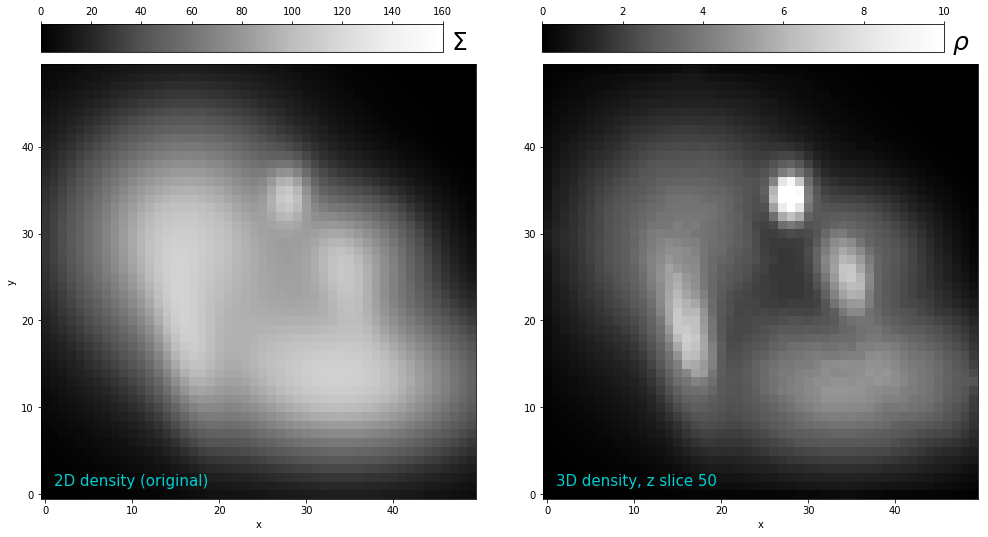

In [6]:
f, ax = plt.subplots(1,2, figsize=(18, 8))

temp=ax[0].imshow(testmap, origin='lower', cmap=plt.cm.Greys_r, interpolation=None, norm=mpl.colors.Normalize(vmin=0, vmax=160))
ax[0].text(x=1, y=1, s='2D density (original)', fontsize=15, color='darkturquoise')

cbaxes0 = f.add_axes([0.151, 0.9, 0.31, 0.05]) 
cb0 = plt.colorbar(temp, cax = cbaxes0, orientation='horizontal', ticklocation='top')
cbaxes0.text(1.02, 0.1, r'$\Sigma$', fontsize=25)

s = 50
temp=ax[1].imshow(testcube[:,:,s], origin='lower', cmap=plt.cm.Greys_r, norm=mpl.colors.Normalize(vmin=0, vmax=10))
ax[1].text(x=1, y=1, s='3D density, z slice '+str(s), fontsize=15, color='darkturquoise')

cbaxes1 = f.add_axes([0.538, 0.9, 0.31, 0.05]) 
cb1 = plt.colorbar(temp, cax = cbaxes1, orientation='horizontal', ticklocation='top')
cbaxes1.text(1.02, 0.1, r'$\rho$', fontsize=25)

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')

plt.subplots_adjust(wspace=0)

#plt.savefig('./plots/aviator_scheme_map_dist.png', dpi=300, bbox_inches='tight')
plt.show()

We can also check the quality of the reconstruction by integrating the 3D reconstruction along z, which should yield a 2D density distribution similar to the original map.

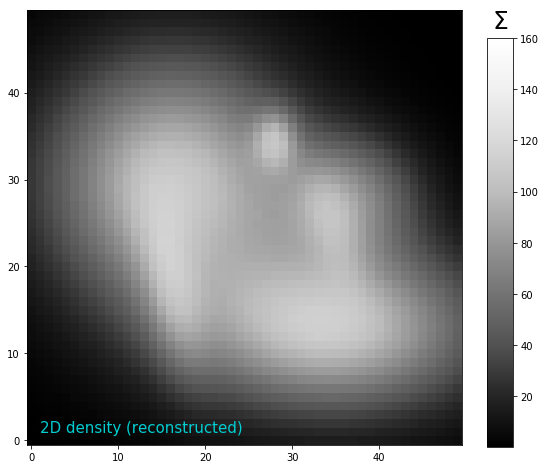

In [7]:
f, ax = plt.subplots(1,1, figsize=(18, 8))

temp=ax.imshow(np.nansum(testcube, axis=(2,)) + residual, origin='lower', cmap=plt.cm.Greys_r, norm=mpl.colors.Normalize(vmax=160))
ax.text(x=1, y=1, s='2D density (reconstructed)', fontsize=15, color='darkturquoise')

cbaxes = f.add_axes([0.7, 0.121, 0.02, 0.71]) 
cb = plt.colorbar(temp, cax = cbaxes)
cb.ax.set_title(r'$\Sigma$', fontsize=25, pad=10)
#plt.savefig('./plots/aviator_scheme_dist_watershed.png', dpi=300, bbox_inches='tight')
plt.show()

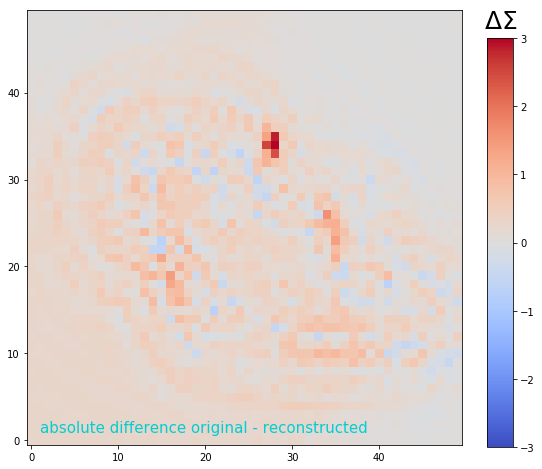

In [8]:
f, ax = plt.subplots(1,1, figsize=(18, 8))

temp=ax.imshow( (testmap - np.nansum(testcube, axis=(2,)) - residual), origin='lower', cmap=plt.cm.coolwarm, norm=mpl.colors.Normalize(vmin=-3, vmax=3))
ax.text(x=1, y=1, s='absolute difference original - reconstructed', fontsize=15, color='darkturquoise')

cbaxes = f.add_axes([0.7, 0.121, 0.02, 0.71]) 
cb = plt.colorbar(temp, cax = cbaxes)
cb.ax.set_title(r'$\Delta\Sigma$', fontsize=25, pad=10)
#plt.savefig('./plots/aviator_scheme_dist_watershed.png', dpi=300, bbox_inches='tight')
plt.show()

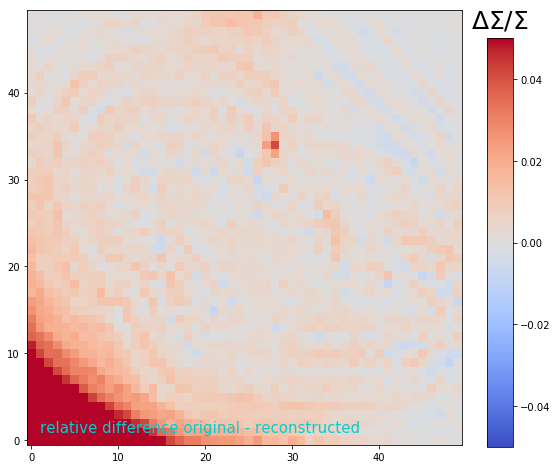

In [9]:
f, ax = plt.subplots(1,1, figsize=(18, 8))

temp=ax.imshow( ((testmap - np.nansum(testcube, axis=(2,)) - residual) / testmap ), origin='lower', cmap=plt.cm.coolwarm, norm=mpl.colors.Normalize(vmin=-0.05, vmax=0.05))
ax.text(x=1, y=1, s='relative difference original - reconstructed', fontsize=15, color='darkturquoise')

cbaxes = f.add_axes([0.7, 0.121, 0.02, 0.71]) 
cb = plt.colorbar(temp, cax = cbaxes)
cb.ax.set_title(r'$\Delta\Sigma/\Sigma$', fontsize=25, pad=10)
#plt.savefig('./plots/aviator_scheme_dist_watershed.png', dpi=300, bbox_inches='tight')
plt.show()

We see that for this example, the relative errors are typically on the order of only a few percent.

This is the end of the tutorial. If you have any further questions, be sure to read the A&A paper describing the AVIATOR algorithm, or contact the authors.